## Libs, data loading

In [4]:
import pmdarima as pm
import sklearn
import pandas as pd
import numpy as np
import glob
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR

In [5]:
num_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
i = 0
df_all = pd.DataFrame()
for file in glob.glob("data/Stocks/*.txt"):
    try:
        df = pd.read_csv(file, sep=',')
    except Exception:
        continue
    df = df[pd.to_numeric(df[num_cols].stack(), errors='coerce').notna().unstack().all(axis=1)]
    enterprise = file[12:-7]
    df["Enterprise"] = enterprise
    df['Date'] = pd.to_datetime(df['Date']) 
    df_all = pd.concat([df_all, df])
    i += 1
    if i == 1:
        break

df_all['Date'] = pd.to_datetime(df_all['Date'])
df_all.drop(columns=['OpenInt'], inplace=True)
df_all.sort_values(by=['Enterprise', 'Date'], inplace=True)

In [7]:
adfuller(df_all["Close"])[1]

2.9145357723229317e-05

In [6]:
split_idx = int(0.8 * len(df_all))

train_data = df_all.iloc[:split_idx + 1]
test_data = df_all.iloc[split_idx:]

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_data = scaler.fit_transform(train_data[["Open", "Close", "Volume", "High", "Low"]])
scaled_train = pd.DataFrame(scaled_data, columns=["Open", "Close", "Volume", "High", "Low"], index=train_data.index)

scaled_data_test = scaler.transform(test_data[["Open", "Close", "Volume", "High", "Low"]])
scaled_test = pd.DataFrame(scaled_data_test, columns=["Open", "Close", "Volume", "High", "Low"], index=test_data.index)


In [9]:
diff_train = scaled_train.diff().dropna()
diff_test = scaled_test.diff().dropna()

display(diff_train.head())
display(diff_test.head())

,Open,Close,Volume,High,Low
1,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.113809,0.113421,-0.004681,0.113860,0.113177
3,0.227619,0.226841,0.002340,0.227720,0.226353
4,-0.068286,-0.068052,0.011702,-0.068316,-0.067906
5,-0.091048,-0.090736,0.002340,-0.091088,-0.090541


,Open,Close,Volume,High,Low
60,-0.068286,-0.049905,-1.470992,-0.068316,-0.031689
61,-0.109257,0.099810,0.243521,-0.040990,0.000000
62,0.013657,-0.095273,-0.065201,-0.054653,-0.203718
63,-0.104705,0.004537,0.160323,-0.093228,0.135812
64,-0.022762,-0.045368,-0.403657,-0.019311,-0.045271


## Results check on ARIMA

In [10]:
arima = pm.AutoARIMA(seasonal = False)
arima.fit(scaled_train["Close"])

/home/drzewo/szt_mag/Stock_exchange_prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/drzewo/szt_mag/Stock_exchange_prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/drzewo/szt_mag/Stock_exchange_prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/drzewo/szt_mag/Stock_exchange_prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/drzewo/szt_mag/Stock_exchange_prediction/.venv

,start_p,2
,d,None
,start_q,2
,max_p,5
,max_d,2
,max_q,5
,start_P,1
,D,None
,start_Q,1
,max_P,2
,max_D,1


In [11]:
print(arima.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   60
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 -16.849
Date:                Fri, 20 Jun 2025   AIC                             35.697
Time:                        19:48:29   BIC                             37.775
Sample:                             0   HQIC                            36.508
                                 - 60                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.1037      0.006     17.528      0.000       0.092       0.115
Ljung-Box (L1) (Q):                   0.44   Jarque-Bera (JB):              1020.99
Prob(Q):                              0.51   Pr

In [12]:
model = ARIMA(diff_train["Close"], order=(1,1,1))
fitted_model = model.fit()
print(fitted_model.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                   59
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -17.478
Date:                Fri, 20 Jun 2025   AIC                             40.956
Time:                        19:48:29   BIC                             47.137
Sample:                             0   HQIC                            43.364
                                 - 59                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2387      0.312     -0.764      0.445      -0.851       0.374
ma.L1         -0.7967      0.234     -3.399      0.001      -1.256      -0.337
sigma2         0.1044      0.009     11.951      0.0

/home/drzewo/szt_mag/Stock_exchange_prediction/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/drzewo/szt_mag/Stock_exchange_prediction/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/drzewo/szt_mag/Stock_exchange_prediction/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


/home/drzewo/szt_mag/Stock_exchange_prediction/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/drzewo/szt_mag/Stock_exchange_prediction/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


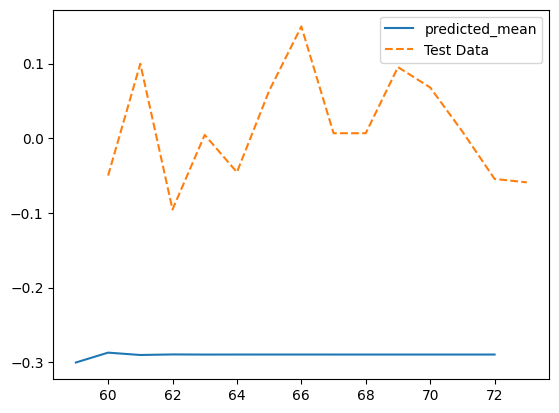

In [13]:
forecast = fitted_model.forecast(steps=len(diff_test))
forecast.plot()

diff_test["Close"].plot(label="Test Data", linestyle='--')

plt.legend()
plt.show()

Arima is useless.

## Results check on Vector Autoregression

In [14]:
model = VAR(diff_train[["Close", "Volume"]])
results = model.fit(ic='aic')
forecast = results.forecast(diff_train[["Close", "Volume"]].values[-results.k_ar:], steps=len(diff_test)-1)

/home/drzewo/szt_mag/Stock_exchange_prediction/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


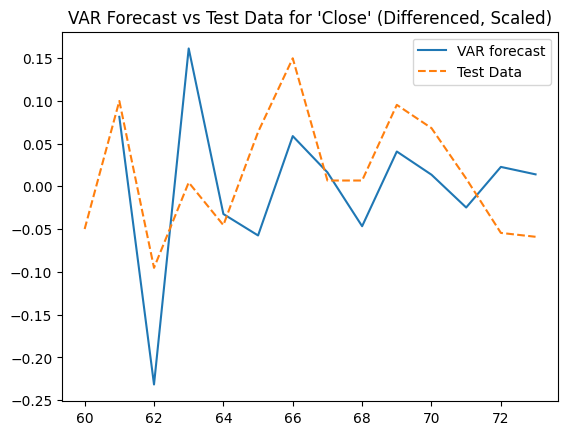

In [15]:
plt.plot(diff_test.index[:len(forecast[:,0])] + 1, forecast[:,0], label="VAR forecast")
diff_test["Close"].plot(label="Test Data", linestyle='--')

plt.title("VAR Forecast vs Test Data for 'Close' (Differenced, Scaled)")
plt.legend()
plt.show()

In [16]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

y_true = diff_test["Close"].values[1:]
y_pred = forecast[:, 0]

r2 = r2_score(y_true, y_pred)

rmse = mean_squared_error(y_true, y_pred,)

mae = mean_absolute_error(y_true, y_pred)

mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

metrics_df = pd.DataFrame({
    "Metric": ["R2 Score", "RMSE", "MAE", "MAPE"],
    "Value": [r2, rmse, mae, mape]
})

display(metrics_df)

,Metric,Value
0,R2 Score,-0.392391
1,RMSE,0.006759
2,MAE,0.068649
3,MAPE,430.390772
